# Klasifikasi Huruf


## Latar Belakang
Seiring berkembangnya zaman, data yang disimpan secara digital jauh lebih mudah diolah daripada data tulisan tangan secara fisik. Banyak lembaga melakukan digitalisasi data karena hal ini. Untuk mempercepat proses pemindahan data menjadi data digital, diperlukan sistem yang dapat mengenali teks dari gambar. Teknologi ini sangat berguna agar proses digitalisasi tidak perlu dilakukan secara manual.
Ada berbagai macam sistem yang bisa mendeteksi teks dari gambar, salah satunya dengan model Machine Learning. Ada banyak algoritma Machine Learning yang bisa mengklasifikasi huruf. 

## Peralatan (Library) yang digunakan

In [ ]:
import pandas as pd
import numpy as np
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, cross_val_score, cross_validate, StratifiedKFold, cross_val_predict

from scipy.stats import pearsonr

## Informasi Dataset
Data training adalah dataset yang sudah tersedia dan digunakan untuk melatih model. Data testing adalah data yang digunakan untuk menguji model. Dalam proyek ini, sumber data adalah data sekunder (raw data yang masih perlu diproses). Data diambil dari Kaggle: A-Z Handwritten Alphabets dalam format csv. Dalam data file, terdapat lebih dari 370.000 data gambar berukuran 28x28 piksel, yang artinya terdapat 784 fitur.

Sumber data tersebut dihasilkan melalui gambar dari NIST (https://www.nist.gov/srd/nist-special-database-19), MNIST, serta sumber lainnya yang kemudian dipusatkan pada kotak berukuran 20x20 piksel sehingga menghasilkan sebuah file yang terdiri dari 370.000 data yang unik. Setiap data berisi 785 atribut, atribut pertama merupakan label klasifikasi huruf dan 784 atribut berikutnya merupakan indikator grey level dari piksel gambar (0-255)

Sumber Dataset: [link](https://archive.ics.uci.edu/dataset/59/letter+recognition)
Dataset yang digunakan masih perlu diproses agar tahap training, testing, dan prediksi lebih efisien. Dataset yang digunakan masih perlu diproses agar tahap training, testing, dan prediksi lebih efisien. Dari 370.00 raw data, diambil 29.169 data yang diharapkan dapat merepresentasi 26 huruf. Proyek UCI Machine Learning: Letter Recognition ([link](https://archive.ics.uci.edu/dataset/59/letter+recognition)) juga melakukan klasifikasi huruf, proyek ini menggunakan dataset yang terdiri dari 17 fitur yang diekstrak dari gambar huruf. Data memiliki 17 fitur dengan tipe data pada setiap fitur adalah integer, kecuali fitur lettr, yaitu kategorikal.

- lettr: huruf kapital (target klasifikasi)
- x-box, y-box, width, high, onpix, x-bar, y-bar, x2bar, y2bar, xybar, x2ybr, xy2br, x-ege, xegvy, y-ege, yegvx: fitur numerik (0-15)

### Tahap Preprocessing Data (dari selected.csv -> converted.csv)

In [ ]:
# Fungsi ubah data GrayScale (784 fitur) ke 17 Fitur
kolom = ['Huruf'] + list(range(784))

data = pd.read_csv('selected.csv', names=kolom)

from scipy.stats import pearsonr

def extract_features(img):
    img = (img > 0).astype(np.uint8)  # binary image

    coords = np.column_stack(np.where(img > 0))
    if coords.shape[0] == 0:
        return [0] * 17

    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    width = x_max - x_min + 1
    height = y_max - y_min + 1
    onpix = np.count_nonzero(img)

    y_indices, x_indices = coords[:, 0], coords[:, 1]
    x_bar = np.mean(x_indices)
    y_bar = np.mean(y_indices)

    x2bar = np.var(x_indices)
    y2bar = np.var(y_indices)
    xybar = np.mean((x_indices - x_bar) * (y_indices - y_bar))
    x2ybr = np.mean((x_indices ** 2) * y_indices)
    xy2br = np.mean(x_indices * (y_indices ** 2))

    x_edge = np.mean(np.abs(np.diff(img, axis=1)).sum(axis=1))
    y_edge = np.mean(np.abs(np.diff(img, axis=0)).sum(axis=0))

    xegvy = pearsonr(np.abs(np.diff(img, axis=1)).sum(axis=1), np.arange(28))[0]
    yegvx = pearsonr(np.abs(np.diff(img, axis=0)).sum(axis=0), np.arange(28))[0]

    return [
        x_min, y_min, width, height, onpix,
        x_bar, y_bar, x2bar, y2bar, xybar,
        x2ybr, xy2br, x_edge, xegvy, y_edge, yegvx
    ]
feature_rows = []

for index, row in data.iterrows():
    pixels = row[1:].values  # ambil 784 pixel
    pixels = pixels.astype(np.uint8)
    image = pixels.reshape((28, 28))
    features = extract_features(image)
    feature_rows.append([row["Huruf"]] + features)  # simpan label + fitur

kolom_fitur = ['Huruf', 'x_min', 'y_min', 'width', 'height', 'onpix',
               'x_bar', 'y_bar', 'x2bar', 'y2bar', 'xybar',
               'x2ybr', 'xy2br', 'x_edge', 'xegvy', 'y_edge', 'yegvx']

fitur_df = pd.DataFrame(feature_rows, columns=kolom_fitur)

fitur_df.to_csv('converted.csv', index=False)

In [ ]:
# Download file converted.csv and test
!gdown 1jPd-dEFxwTh5O19-Nbcg3rwmyaYgiyaR -O converted.csv
!gdown https://drive.google.com/drive/folders/1nKHlssJ3NrFCEjw-ZG3tTqizcn2_1qIv?usp=drive_link -O /content/ --folder

Downloading...
From: https://drive.google.com/uc?id=1jPd-dEFxwTh5O19-Nbcg3rwmyaYgiyaR
To: /content/converted.csv
100% 6.44M/6.44M [00:00<00:00, 36.1MB/s]
Retrieving folder contents
Processing file 1TISmFADkEEuBDqCtka9PhMqlKMCucSNU A.png
Processing file 1ydIwwMv1p9saEIeOi9QBaOTvHihIwyXG B.png
Processing file 1IZnvLQy4ex_GQHhSk7GfWb71YKy9aYpL D.png
Processing file 15KLS_VLAvuw_FnRPrYBI4eCX0mAyV-C6 E.png
Processing file 19axg_dAiahjGhHXD-5SYAyHYXgCQ1ono F.png
Processing file 1-OHi75-Iaa_Kr1k8-OPBhFcnMDTUYmpY G.png
Processing file 1cNIAjOScbEq-INpP5fKs3zqF6RUOOzl_ H.png
Processing file 1144hLvSMSHyUI1zMsFOZN6-YNmpjCDFO I.png
Processing file 1g5JIFWFQ1I-x62rW0NYqRxwxzY2lIvPp J.png
Processing file 1YID0w97SNROtWyqHftVkbHunXIJZuZTY K.png
Processing file 1FDTdgBLE4opBQCM6hIvq6i2e3_e19lSY L.png
Processing file 18RoGTa0MtK6ex9zfmmta_86xmrFtQ018 M.png
Processing file 1Z8dlnG-rhB1rgCHL5K8xGj64QujJ7VSz N.png
Processing file 180hC-wNBVXM1d5gHJQgWguHGjFSRY3kM O.png
Processing file 1D9bDkRS8c3RiW6ZJh5

In [4]:
df = pd.read_csv('converted.csv')

First 5 rows:
   Huruf  x_min  y_min  width  height  onpix      x_bar      y_bar      x2bar  \
0      0      7      4     14      20    136  14.007353  13.602941  11.257299   
1      0      6      4     16      20    186  14.645161  13.994624  18.196670   
2      0      5      4     18      20    200  13.930000  13.470000  25.975100   
3      0      6      4     16      20    145  13.910345  14.420690  12.398859   
4      0      5      4     18      20    120  14.383333  13.408333  20.869722   

       y2bar      xybar        x2ybr        xy2br      x_edge     xegvy  \
0  23.768815  -1.026492  2819.602941  2918.911765  246.857143  0.111886   
1  27.715025 -10.340617  2982.580645  2991.258065  283.428571  0.219237   
2  28.149100  -5.867100  2845.570000  2756.850000  329.142857  0.125516   
3  26.947158  -5.879524  2841.227586  3102.413793  265.142857  0.230048   
4  24.041597  -9.423194  2856.350000  2651.700000  265.142857  0.071002   

       y_edge     yegvx  
0  155.428571  0.06899

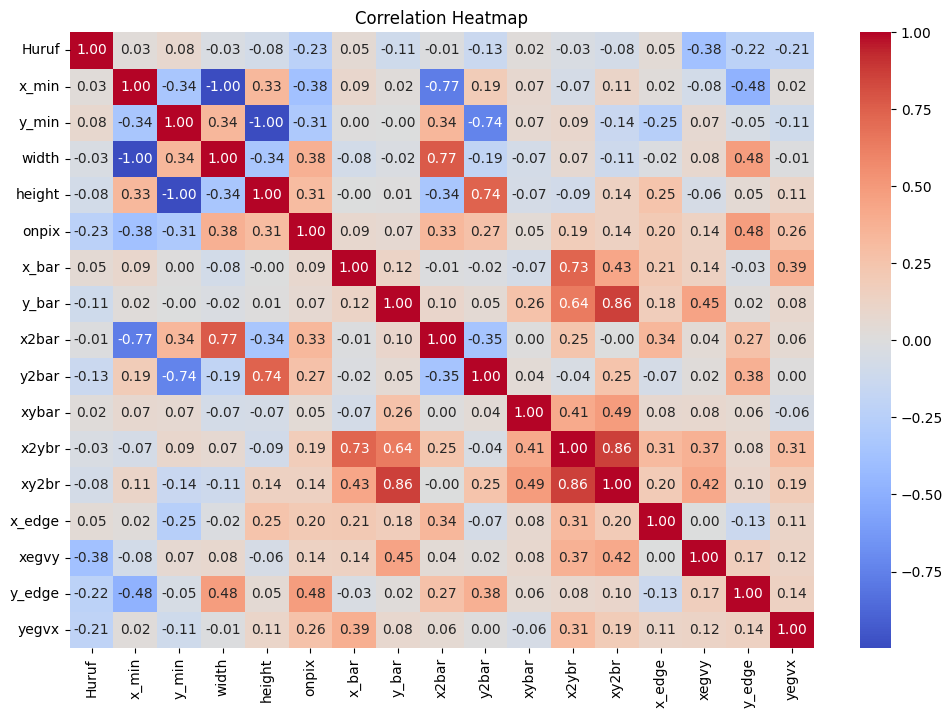

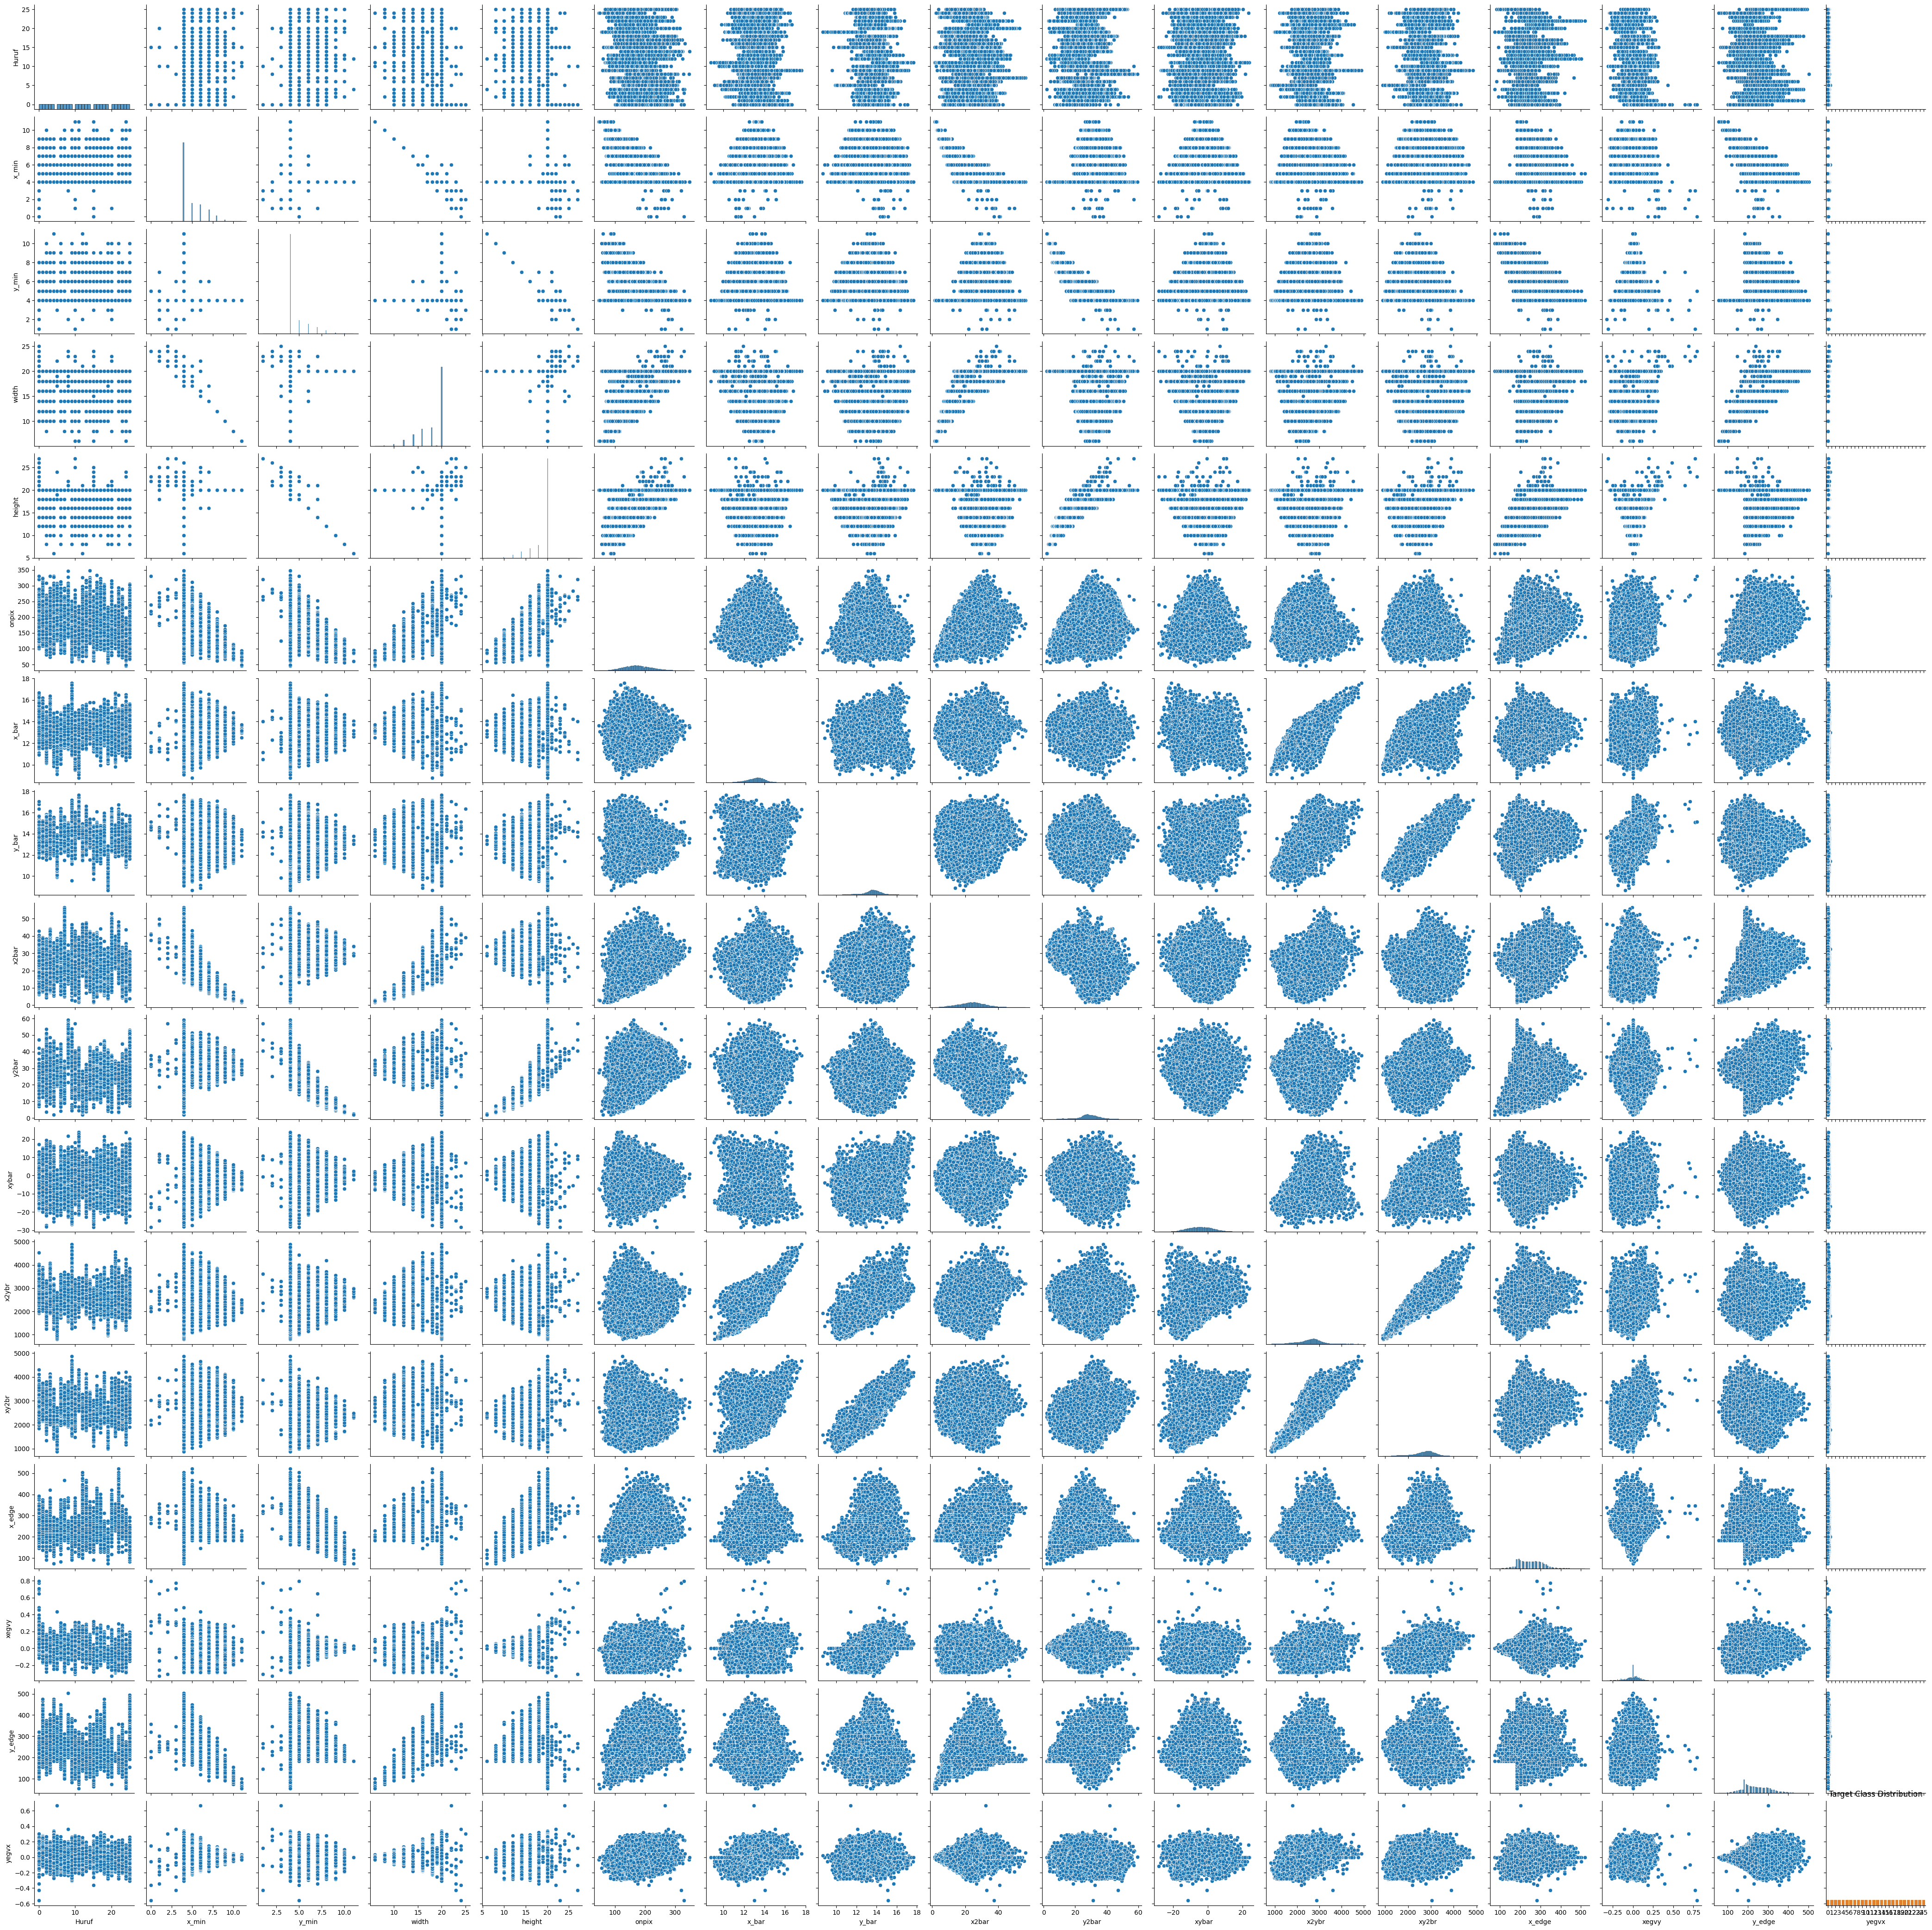

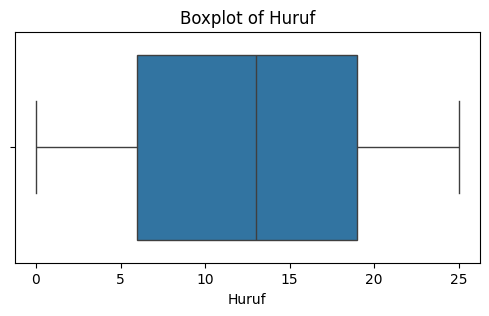

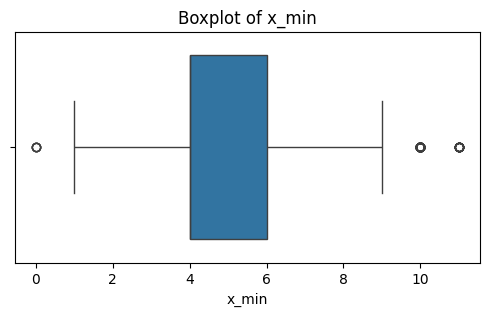

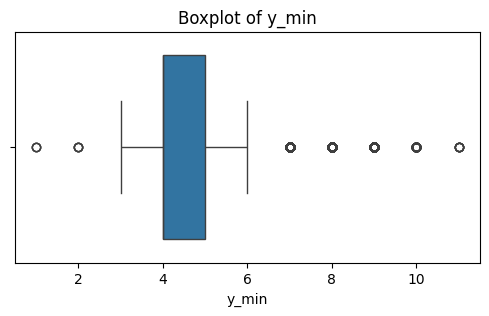

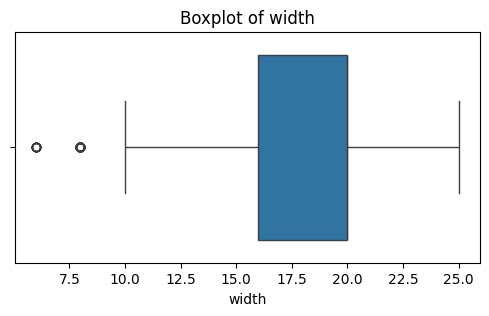

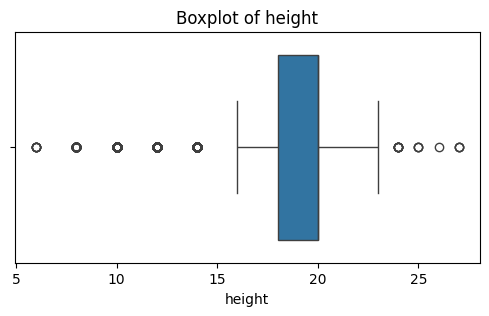

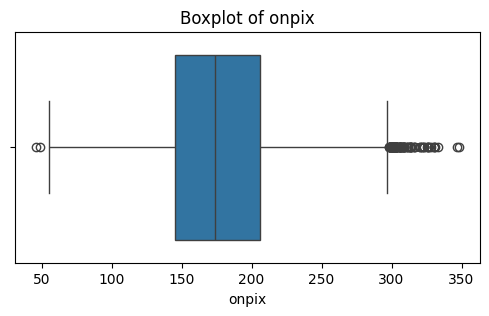

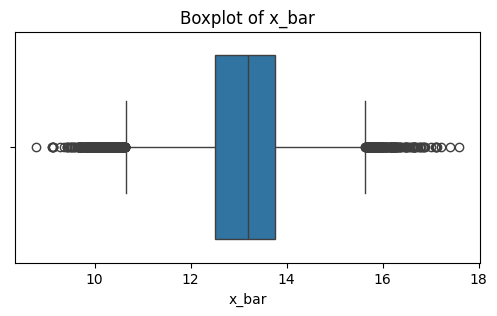

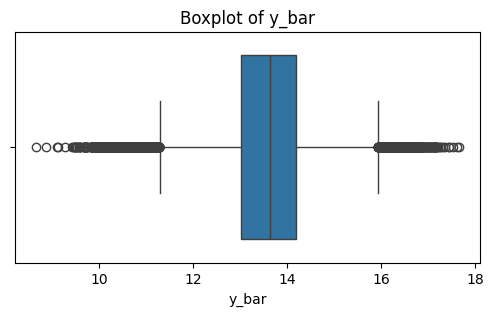

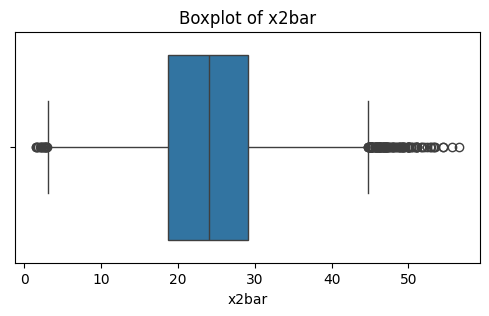

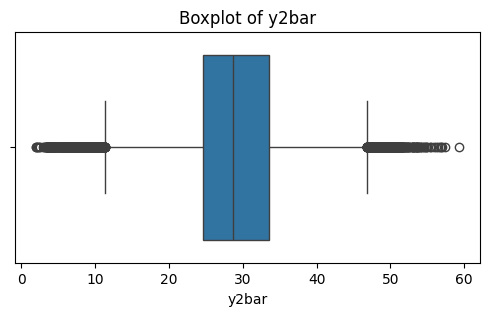

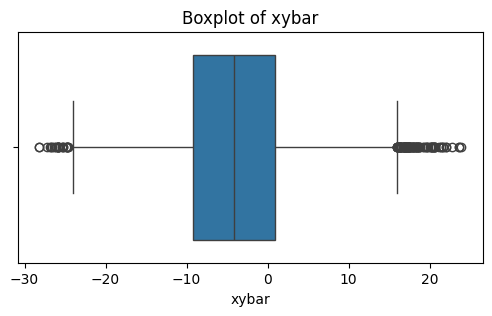

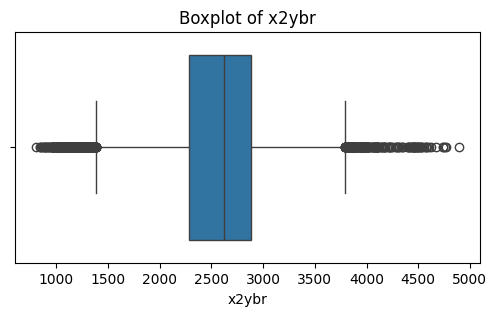

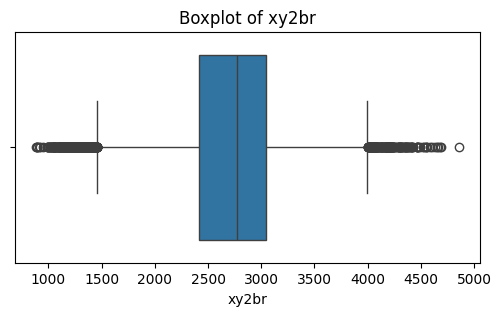

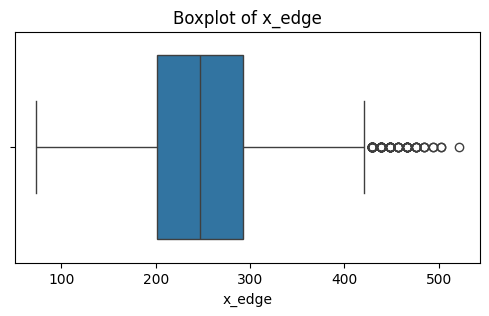

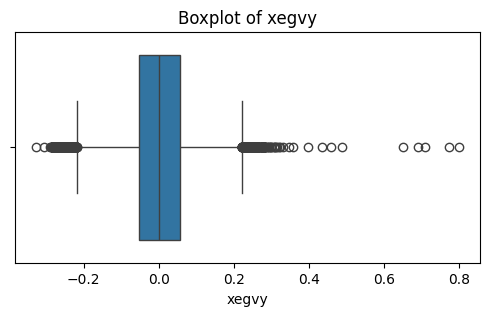

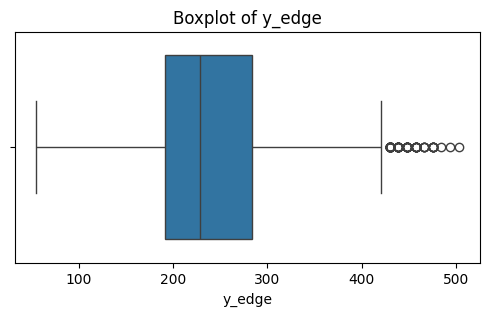

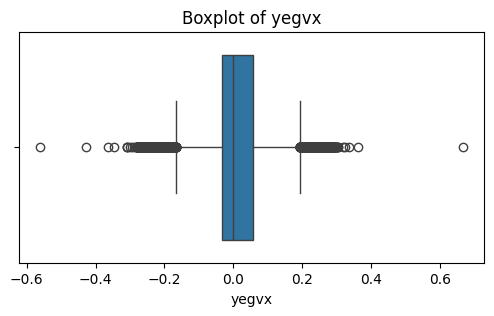

In [ ]:
# Visualisasi Data (EDA) Pake Grafik PairPlot

print("First 5 rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nSummary Statistics:")
print(df.describe())

print("\nMissing values per column:")
print(df.isnull().sum())

print(f"Number of duplicate rows: {df.duplicated().sum()}")
print(df.dtypes)

plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

sns.pairplot(df)                           # scatter plots of relationships

sns.countplot(x='Huruf', data=df)
plt.title("Target Class Distribution")
plt.show()

numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot of {col}')
    plt.show()                             # outliers

## Penjelasan Pelatihan dan Pengujian Data (secara umum)
Dataset akan diproses menjadi dataset baru yang terdiri dari 17 fitur karakteristik huruf, kemudian dilatih dan diuji menggunakan 4 model classification, antara lain Random Forest Classifier, K-Nearest Neighbors Classifier, Multilayer Perceptron, dan XGBoost Classifier. Sebelum itu, metode train-test-split digunakan untuk membagi data training dan data testing. Proyek ini memisahkan 20% data untuk diuji dan 80% data untuk dilatih. Berikut implementasinya dalam bahasa python:

In [5]:
y = df.iloc[:, 0]
X = df.iloc[:, 1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Jika Best Model Tersedia

In [7]:

with open('best_xgb_model.pkl', 'rb') as file:
    xgb_model = pickle.load(file)

with open('best_mlp_model.pkl', 'rb') as file:
    mlp_model = pickle.load(file)

with open('best_knn_model.pkl', 'rb') as file:
    knn_model = pickle.load(file)

with open('best_rf_model.pkl', 'rb') as file:
    rf_model = pickle.load(file)

knn_y_pred = knn_model.predict(X_test)
mlp_y_pred = mlp_model.predict(X_test)
rf_y_pred = rf_model.predict(X_test)
xgb_y_pred = xgb_model.predict(X_test)

### Pembutan Pipeline untuk Semua Model

In [8]:
# Pipeline untuk KNN
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Pipeline untuk RF
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

# Pipeline: Scaling + XGBoost
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Optional untuk XGBoost
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])

# Pipeline: Scaling + MLP Classifier
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(max_iter=5000, random_state=42))
])



### Scoring

In [9]:
def evaluate_cv_results(model, X, y, cv, label):
    y_pred = cross_val_predict(model, X, y, cv=cv)
    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y, y_pred, average='weighted', zero_division=0)

    print(f"=== {label} ===")
    print(classification_report(y, y_pred))
    return {
        'CV Type': label,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    }

### Model Pertama: KNN


K-Nearest Neighbors adalah cara mengklasifikasi suatu data dengan melihat data di sekelilingnya. Algoritma tidak secara langsung belajar dari data training, tetapi menyimpan dataset dan baru mempelajarinya pada saat klasifikasi. Nilai k pada k-Nearest Neighbors adalah angka yang menunjukkan jumlah tetangga yang perlu dilihat waktu mengambil keputusan.
Algoritma K-Nearest Neighbors yang digunakan pada proyek ini adalah dari sklearn.neighbors. Secara default, metode perhitungan jarak untuk mengidentifikasi tetangga terdekat adalah Euclidean Distance yang mengikut rumus berikut.
$$
\text{distance}(x, X_i) = \sqrt{ \sum_{j=1}^{d} (x_j - X_{ij})^2 }
$$

Keterangan:
- $x$ = vektor fitur dari data yang ingin diprediksi  
- $X_i$ = vektor fitur dari data latih ke-$i$  
- $d$ = jumlah fitur (dimensi)  
- $(x_j - X_{ij})^2$ = selisih kuadrat antara fitur ke-$j$ dari $x$ dan $X_i$




In [ ]:
# Parameter grid untuk KNN
knn_param_grid = {
    'knn__n_neighbors': list(range(1, 11)),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

# GridSearchCV untuk KNN
knn_grid_search = GridSearchCV(estimator=knn_pipeline,
                               param_grid=knn_param_grid,
                               cv=3,
                               scoring='accuracy',
                               n_jobs=-1,
                               verbose=2)

# Training
knn_grid_search.fit(X_train, y_train)

# Prediksi
knn_y_pred = knn_grid_search.predict(X_test)

# Simpan best model
with open('best_knn_model.pkl', 'wb') as f:
    pickle.dump(knn_grid_search.best_estimator_, f)

# Simpan semua hasil GridSearch
knn_results_df = pd.DataFrame(knn_grid_search.cv_results_)
knn_results_df.to_csv('knn_gridsearch_results.csv', index=False)

# Hitung metrik evaluasi
acc_knn = accuracy_score(y_test, knn_y_pred)
prec_knn = precision_score(y_test, knn_y_pred, average='weighted')
rec_knn = recall_score(y_test, knn_y_pred, average='weighted')
f1_knn = f1_score(y_test, knn_y_pred, average='weighted')

# Tampilkan hasil
print(f"Accuracy: {acc_knn:.4f}")
print(f"Precision: {prec_knn:.4f}")
print(f"Recall: {rec_knn:.4f}")
print(f"F1 Score: {f1_knn:.4f}")

# Atau, tampilkan laporan lengkap
print("\nClassification Report:")
print(classification_report(y_test, knn_y_pred))

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Accuracy: 0.8238
Precision: 0.8263
Recall: 0.8238
F1 Score: 0.8232

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       203
           1       0.74      0.70      0.72       205
           2       0.81      0.84      0.82       223
           3       0.71      0.61      0.66       233
           4       0.88      0.79      0.83       223
           5       0.96      0.97      0.97       217
           6       0.79      0.73      0.76       234
           7       0.70      0.76      0.73       225
           8       0.92      0.96      0.94       240
           9       0.89      0.89      0.89       229
          10       0.86      0.72      0.78       248
          11       0.94      0.98      0.96       255
          12       0.93      0.88      0.90       227
          13       0.70      0.68      0.69       237
          14       0.64      0.89   

#### Penjelasan mengenai Visualisasi

Dalam implementasinya menggunakan bahasa python untuk menunjukkan proses pelatihan model K-Nearest Neighbors (KNN) dengan pipeline, hyperparameter tuning (GridSearchCV), dan evaluasi model menggunakan Cross Validation (baik K-Fold biasa maupun StratifiedKFold), berikut akurasi dari model dengan berbagai metode evaluasi:


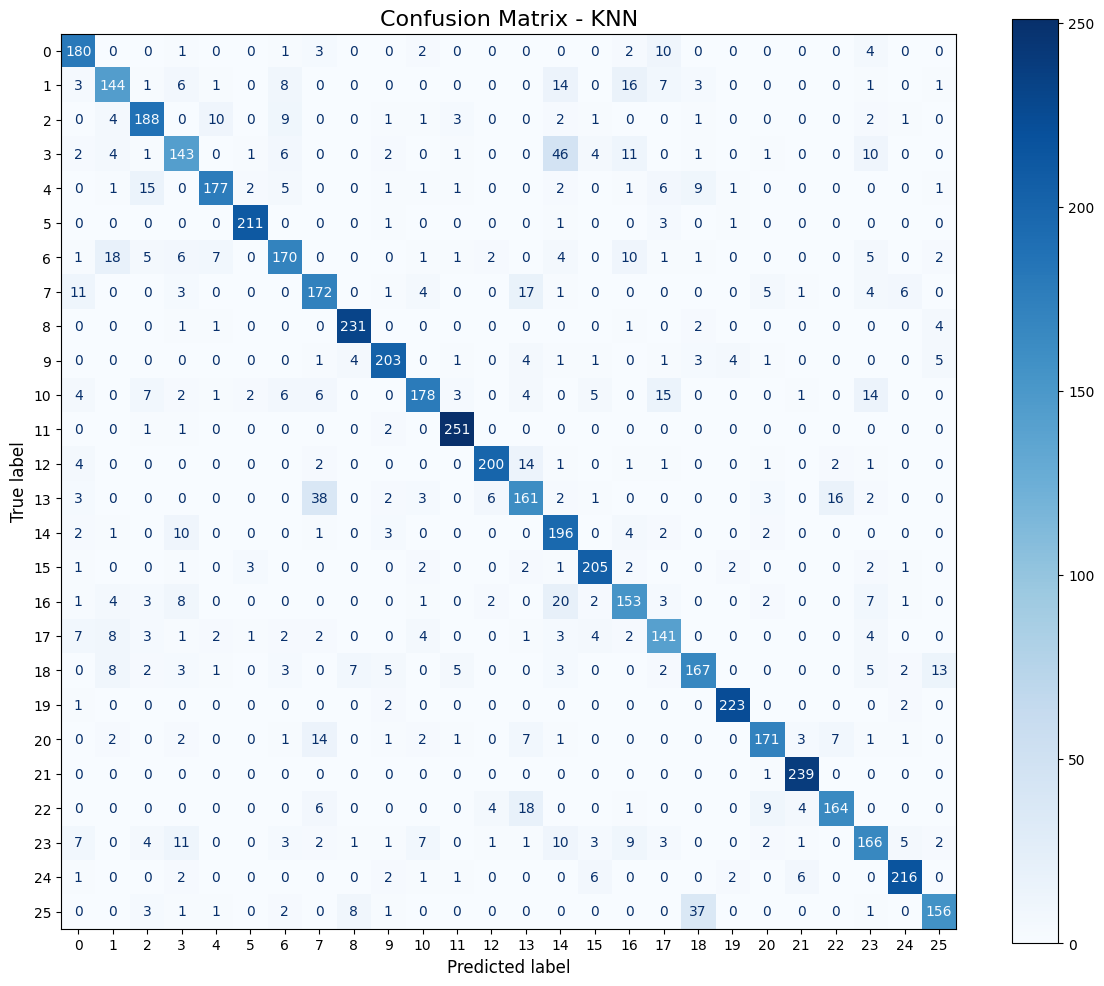

In [ ]:
# Confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
cm = confusion_matrix(y_test, knn_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap='Blues', colorbar=True)
ax.set_title("Confusion Matrix - KNN", fontsize=16)
ax.set_xlabel("Predicted label", fontsize=12)
ax.set_ylabel("True label", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


In [16]:
# K-Fold
knn_kf = KFold(n_splits=3, shuffle=True, random_state=42)
knn_results_kf = evaluate_cv_results(knn_pipeline, X_train, y_train, knn_kf, 'K-Fold')

# Stratified K-Fold
knn_skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
knn_results_skf = evaluate_cv_results(knn_pipeline, X_train, y_train, knn_skf, 'Stratified K-Fold')

# Stratified + Best Model
knn_results_best = evaluate_cv_results(knn_model, X_train, y_train, knn_skf, 'Stratified K-Fold + Best Estimator')

=== K-Fold ===
              precision    recall  f1-score   support

           0       0.71      0.85      0.78       918
           1       0.64      0.73      0.68       917
           2       0.72      0.84      0.78       899
           3       0.60      0.58      0.59       889
           4       0.86      0.78      0.82       899
           5       0.96      0.98      0.97       905
           6       0.74      0.66      0.70       888
           7       0.66      0.78      0.71       897
           8       0.88      0.95      0.91       880
           9       0.91      0.86      0.88       893
          10       0.82      0.69      0.75       874
          11       0.93      0.97      0.95       867
          12       0.90      0.90      0.90       895
          13       0.69      0.64      0.66       885
          14       0.66      0.89      0.76       901
          15       0.90      0.91      0.90       900
          16       0.76      0.69      0.73       915
          17

In [17]:
# Gabungkan semua hasil dalam DataFrame
final_results_df = pd.DataFrame([
    {key: f"{value*100:.2f}%" if isinstance(value, float) else value for key, value in result.items()}
    for result in [knn_results_kf, knn_results_skf, knn_results_best]
])
display(final_results_df)

CV Type Accuracy Precision  Recall F1 Score
0                              K-Fold   80.05%    80.44%  80.05%   79.97%
1                   Stratified K-Fold   80.04%    80.37%  80.04%   79.96%
2  Stratified K-Fold + Best Estimator   80.82%    81.02%  80.82%   80.72%

### Model Kedua: Random Forest


Random Forest Classifier merupakan salah satu algoritma machine learning yang menghasilkan model dari berbagai pohon keputusan. Kumpulan pohon keputusan akan dilatih secara independen dengan teknik bootstrap aggregating (bagging). Bootstrap adalah teknik statistik yang memungkinkan estimasi distribusi sampel dengan melakukan resampling (pengambilan sampel berulang kali).
Untuk klasifikasi dan prediksi, Random Forest dapat menghitung tingkat kepentingan (feature importance), salah satunya adalah metode Mean Decrease in Accuracy. Metode Mean Decrease in Accuracy akan menghitung akurasi pada data OOB. Terdapat sekitar 36.8% dari data asli yang tidak termasuk dalam bootstrap sample untuk setiap pohon tertentu yang disebut sebagai Out-of-Bag (OOB) samples. Jika akurasi turun secara signifikan, maka fitur tersebut penting. Pengetahuan ini akan mempengaruhi bagaimana setiap pohon menentukan prediksi. Setelah setiap pohon memberikan hasil prediksinya, hasil prediksi yang sama dan terbanyak akan dipilih sebagai hasil prediksi final. Teknik ini disebut sebagai Voting Majority:


$$
\hat{y} = \arg\max_c \sum_{i=1}^{n} I(h_i(X) = c)
$$

Keterangan:
- $\hat{y}$ = hasil prediksi akhir  
- $c$ = label kelas hasil klasifikasi  
- $I(h_i(X) = c)$ = fungsi indikator (bernilai 1 jika pohon ke-$i$ memprediksi $c$, 0 jika tidak)  
- $n$ = jumlah pohon dalam Random Forest


In [ ]:
# Parameter grid untuk Random Forest
rf_param_grid = {
    'rf__n_estimators': [50, 100, 150],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5, 10]
}

# GridSearchCV untuk Random Forest
rf_grid_search = GridSearchCV(estimator=rf_pipeline,
                              param_grid=rf_param_grid,
                              cv=3,
                              scoring='accuracy',
                              n_jobs=-1,
                              verbose=2)

# Training
rf_grid_search.fit(X_train, y_train)

# Prediksi
rf_y_pred = rf_grid_search.predict(X_test)

# Simpan best model
with open('best_rf_model.pkl', 'wb') as f:
    pickle.dump(rf_grid_search.best_estimator_, f)

# Simpan semua hasil GridSearch
rf_results_df = pd.DataFrame(rf_grid_search.cv_results_)
rf_results_df.to_csv('rf_gridsearch_results.csv', index=False)

# Hitung metrik evaluasi
acc_rf = accuracy_score(y_test, rf_y_pred)
prec_rf = precision_score(y_test, rf_y_pred, average='weighted')
rec_rf = recall_score(y_test, rf_y_pred, average='weighted')
f1_rf = f1_score(y_test, rf_y_pred, average='weighted')

# Tampilkan hasil
print(f"Accuracy: {acc_rf:.4f}")
print(f"Precision: {prec_rf:.4f}")
print(f"Recall: {rec_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")

# Atau, tampilkan laporan lengkap
print("\nClassification Report:")
print(classification_report(y_test, rf_y_pred))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END rf__max_depth=None, rf__min_samples_split=2, rf__n_estimators=50; total time=   3.7s
[CV] END rf__max_depth=None, rf__min_samples_split=2, rf__n_estimators=50; total time=   4.4s
[CV] END rf__max_depth=None, rf__min_samples_split=2, rf__n_estimators=50; total time=   4.9s
[CV] END rf__max_depth=None, rf__min_samples_split=2, rf__n_estimators=100; total time=   9.1s
[CV] END rf__max_depth=None, rf__min_samples_split=2, rf__n_estimators=100; total time=   7.8s
[CV] END rf__max_depth=None, rf__min_samples_split=2, rf__n_estimators=100; total time=   8.4s
[CV] END rf__max_depth=None, rf__min_samples_split=5, rf__n_estimators=50; total time=   3.2s
[CV] END rf__max_depth=None, rf__min_samples_split=2, rf__n_estimators=150; total time=  12.4s
[CV] END rf__max_depth=None, rf__min_samples_split=5, rf__n_estimators=50; total time=   4.2s
[CV] END rf__max_depth=None, rf__min_samples_split=2, rf__n_estimators=150; total time=  

Exception ignored in: <function ResourceTracker.__del__ at 0x7f8c148e7f60>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7fde200eff60>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f6eb32e7f60>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multip

#### Penjelasan Visualisasi Hasil

Dalam implementasinya menggunakan bahasa python untuk menunjukkan proses pelatihan model Random Forest Classifier dengan pipeline, hyperparameter tuning (GridSearchCV), dan evaluasi model menggunakan Cross Validation (baik K-Fold biasa maupun StratifiedKFold), berikut akurasi dari model dengan berbagai metode evaluasi:

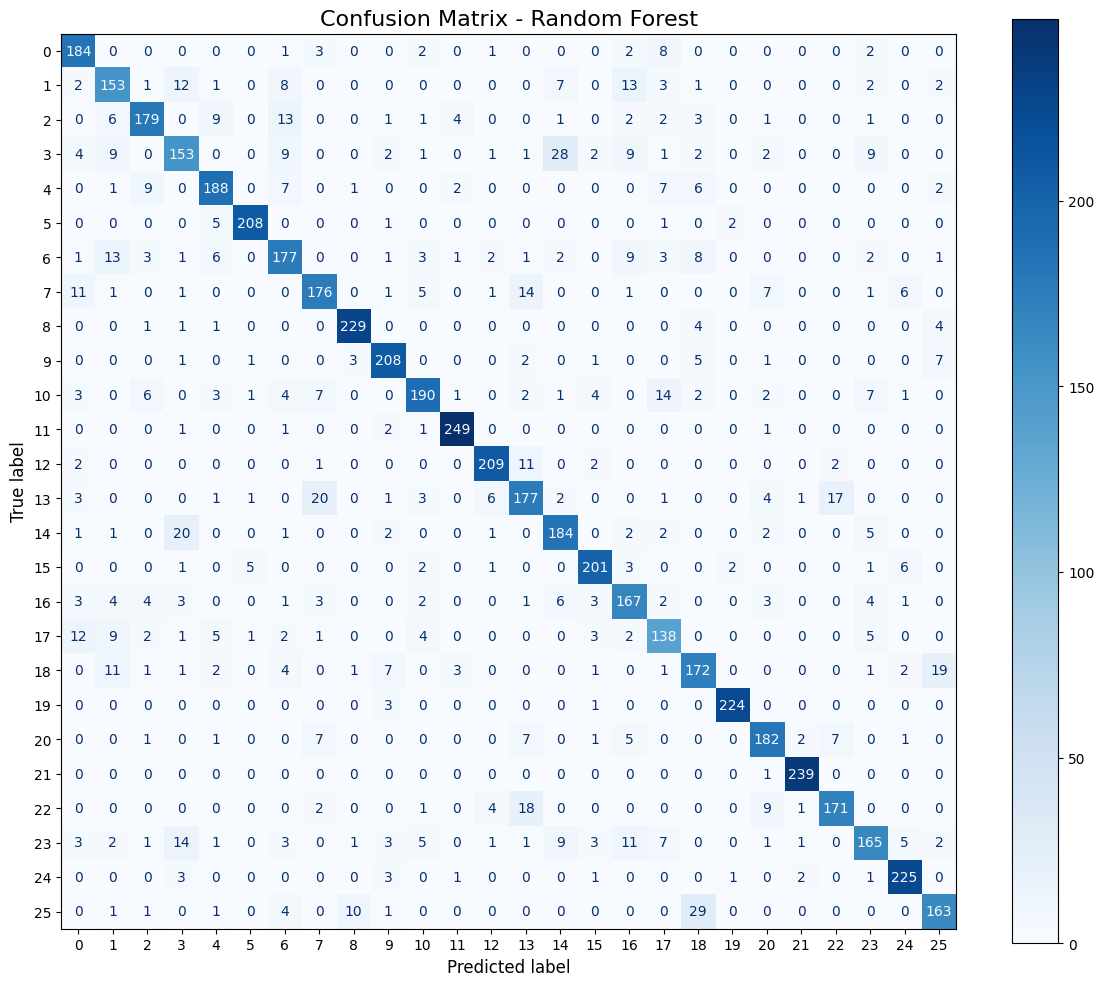

In [10]:
# Confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
cm = confusion_matrix(y_test, rf_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap='Blues', colorbar=True)
ax.set_title("Confusion Matrix - Random Forest", fontsize=16)
ax.set_xlabel("Predicted label", fontsize=12)
ax.set_ylabel("True label", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


In [18]:
# K-Fold Cross Validation
rf_kf = KFold(n_splits=3, shuffle=True, random_state=42)
results_rf_kf = evaluate_cv_results(rf_pipeline, X_train, y_train, rf_kf, 'RF - K-Fold')

# Stratified K-Fold Cross Validation
rf_skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
results_rf_skf = evaluate_cv_results(rf_pipeline, X_train, y_train, rf_skf, 'RF - Stratified K-Fold')

# Stratified K-Fold dengan Best Estimator
results_rf_best = evaluate_cv_results(rf_model, X_train, y_train, rf_skf, 'RF - Stratified K-Fold + Best Estimator')

=== RF - K-Fold ===
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       918
           1       0.72      0.73      0.72       917
           2       0.81      0.83      0.82       899
           3       0.67      0.60      0.63       889
           4       0.83      0.82      0.83       899
           5       0.97      0.98      0.97       905
           6       0.73      0.68      0.70       888
           7       0.74      0.77      0.76       897
           8       0.93      0.94      0.93       880
           9       0.87      0.87      0.87       893
          10       0.81      0.73      0.77       874
          11       0.93      0.97      0.95       867
          12       0.92      0.93      0.92       895
          13       0.71      0.69      0.70       885
          14       0.76      0.84      0.80       901
          15       0.87      0.90      0.89       900
          16       0.75      0.76      0.76       915
       

In [19]:
final_results_df = pd.DataFrame([
    {key: f"{value*100:.2f}%" if isinstance(value, float) else value for key, value in result.items()}
    for result in [results_rf_kf, results_rf_skf, results_rf_best]
])
display(final_results_df)

CV Type Accuracy Precision  Recall F1 Score
0                              RF - K-Fold   82.09%    81.98%  82.09%   82.00%
1                   RF - Stratified K-Fold   82.00%    81.89%  82.00%   81.91%
2  RF - Stratified K-Fold + Best Estimator   82.12%    82.02%  82.12%   82.03%

### Model Ketiga: MLP

Multilayer Perceptron (MLP) adalah sebuah jaringan saraf artifisial yang terdiri dari beberapa lapisan neuron. MLP terdiri dari satu input layer, satu atau lebih hidden layer, dan satu output layer. Input layer terdiri dari neuron yang menerima data input awal, dengan tiap neuron mewakili fitur dimensi data input. Sehingga, jumlah neuron dalam lapisan input ditentukan oleh jumlah fitur data input. Setelah input layer, terdapat satu atau lebih lapisan neuron yang disebut dengan hidden layer, jumlah lapisan ini merupakan hyperparameter yang dapat diubah sesuai kebutuhan. Terakhir, output layer, merupakan lapisan yang terdiri dari neuron sebagai output akhir. Jumlah neuronnya bergantung pada jenis prediksi yang dibutuhkan.

In [ ]:
# Parameter grid untuk GridSearchCV
mlp_param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    # 'mlp__activation': ['relu', 'tanh'],
    # 'mlp__solver': ['adam', 'sgd'],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    # 'mlp__learning_rate': ['constant', 'adaptive']
}

# Grid Search
mlp_grid_search = GridSearchCV(
    estimator=mlp_pipeline,
    param_grid=mlp_param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Fit ke data latih
mlp_grid_search.fit(X_train, y_train)

# Prediksi
mlp_y_pred = mlp_grid_search.predict(X_test)

# Simpan best model
with open('best_mlp_model.pkl', 'wb') as f:
    pickle.dump(mlp_grid_search.best_estimator_, f)

# Simpan semua hasil GridSearch
results_df = pd.DataFrame(mlp_grid_search.cv_results_)
results_df.to_csv('mlp_gridsearch_results.csv', index=False)

# Hitung metrik evaluasi
acc_mlp = accuracy_score(y_test, mlp_y_pred)
prec_mlp = precision_score(y_test, mlp_y_pred, average='weighted')
rec_mlp = recall_score(y_test, mlp_y_pred, average='weighted')
f1_mlp = f1_score(y_test, mlp_y_pred, average='weighted')

# Tampilkan hasil
print(f"Accuracy: {acc_mlp:.4f}")
print(f"Precision: {prec_mlp:.4f}")
print(f"Recall: {rec_mlp:.4f}")
print(f"F1 Score: {f1_mlp:.4f}")

# Atau, tampilkan laporan lengkap
print("\nClassification Report:")
print(classification_report(y_test, mlp_y_pred))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Accuracy: 0.9006
Precision: 0.9016
Recall: 0.9006
F1 Score: 0.9007

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.90       203
           1       0.82      0.83      0.83       205
           2       0.95      0.90      0.92       223
           3       0.88      0.85      0.87       233
           4       0.93      0.87      0.90       223
           5       0.99      0.98      0.98       217
           6       0.82      0.85      0.84       234
           7       0.87      0.77      0.82       225
           8       0.96      0.95      0.96       240
           9       0.91      0.94      0.92       229
          10       0.89      0.91      0.90       248
          11       0.98      0.97      0.97       255
          12       0.95      0.95      0.95       227
          13       0.85      0.82      0.84       237
          14       0.85      0.88    

#### Penjelasan Visualisasi

Dalam implementasinya menggunakan bahasa python untuk menunjukkan proses pelatihan model Multilayer Perceptron Classifier dengan pipeline, hyperparameter tuning (GridSearchCV), dan evaluasi model menggunakan Cross Validation (baik K-Fold biasa maupun StratifiedKFold), berikut akurasi dari model dengan berbagai metode evaluasi:

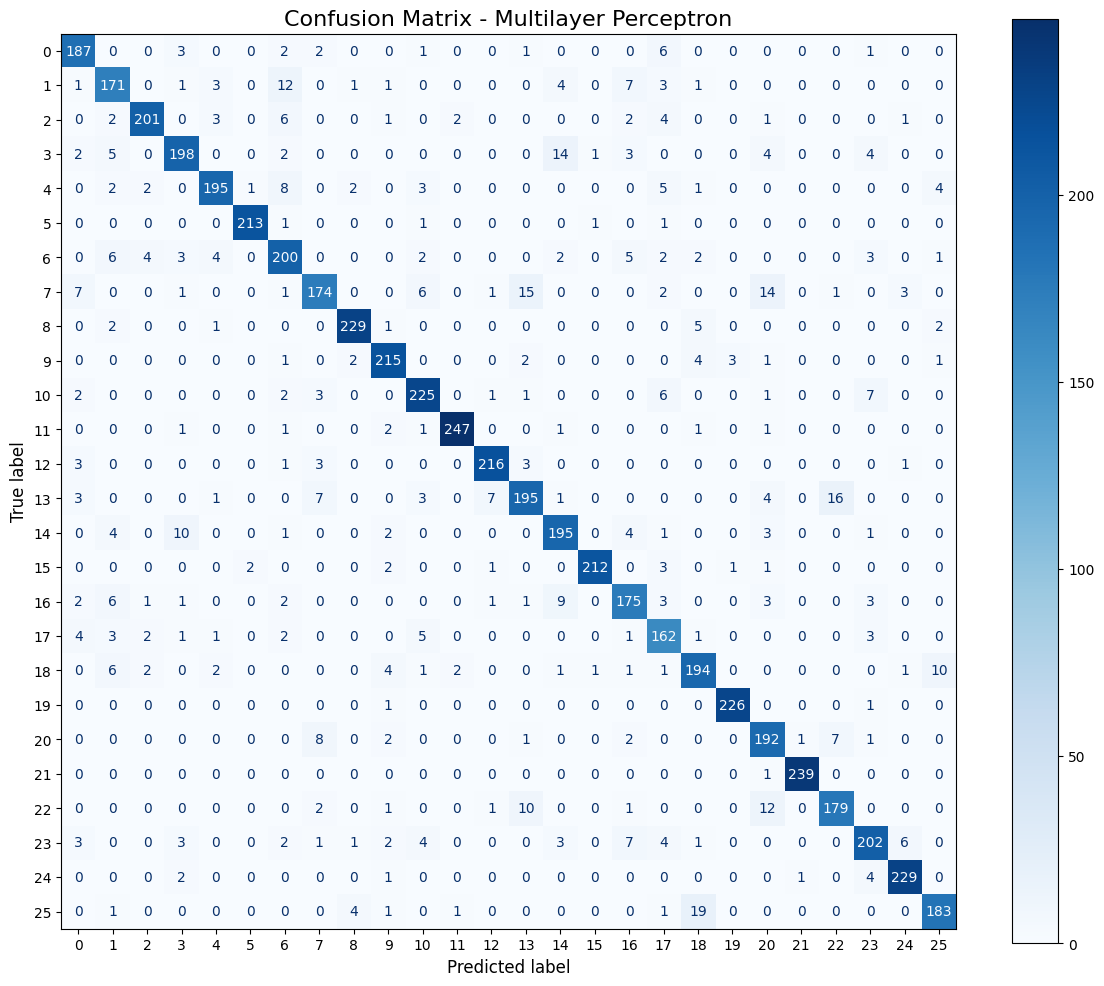

In [ ]:
# Confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
cm = confusion_matrix(y_test, mlp_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap='Blues', colorbar=True)
ax.set_title("Confusion Matrix - Multilayer Perceptron", fontsize=16)
ax.set_xlabel("Predicted label", fontsize=12)
ax.set_ylabel("True label", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


In [20]:
# MLP - K-Fold Cross Validation
mlp_kf = KFold(n_splits=3, shuffle=True, random_state=42)
results_mlp_kf = evaluate_cv_results(mlp_pipeline, X_train, y_train, mlp_kf, 'MLP - K-Fold')

# MLP - Stratified K-Fold Cross Validation
mlp_skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
results_mlp_skf = evaluate_cv_results(mlp_pipeline, X_train, y_train, mlp_skf, 'MLP - Stratified K-Fold')

# MLP - Stratified K-Fold dengan Best Estimator
results_mlp_best = evaluate_cv_results(mlp_model, X_train, y_train, mlp_skf, 'MLP - Stratified K-Fold + Best Estimator')


=== MLP - K-Fold ===
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       918
           1       0.82      0.83      0.82       917
           2       0.91      0.90      0.91       899
           3       0.83      0.83      0.83       889
           4       0.88      0.88      0.88       899
           5       0.97      0.98      0.98       905
           6       0.80      0.80      0.80       888
           7       0.82      0.81      0.82       897
           8       0.94      0.95      0.94       880
           9       0.92      0.93      0.92       893
          10       0.84      0.82      0.83       874
          11       0.96      0.97      0.97       867
          12       0.96      0.94      0.95       895
          13       0.80      0.84      0.82       885
          14       0.87      0.88      0.87       901
          15       0.93      0.94      0.93       900
          16       0.84      0.84      0.84       915
      

In [21]:
final_results_df = pd.DataFrame([
    {key: f"{value*100:.2f}%" if isinstance(value, float) else value for key, value in result.items()}
    for result in [results_mlp_kf, results_mlp_skf, results_mlp_best]
])
display(final_results_df)

CV Type Accuracy Precision  Recall  \
0                              MLP - K-Fold   88.41%    88.42%  88.41%   
1                   MLP - Stratified K-Fold   88.13%    88.15%  88.13%   
2  MLP - Stratified K-Fold + Best Estimator   88.58%    88.57%  88.58%   

  F1 Score  
0   88.41%  
1   88.13%  
2   88.56%

### Model Keempat: XGBoost

In [ ]:
# Hyperparameter grid
xgb_param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.8, 1],
    'xgb__colsample_bytree': [0.8, 1]
}

# Grid Search
xgb_grid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=xgb_param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Fit to training data
xgb_grid_search.fit(X_train, y_train)

# Predict
xgb_y_pred = xgb_grid_search.predict(X_test)

# Save best model
with open('best_xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_grid_search.best_estimator_, f)

# Save GridSearch results
results_df = pd.DataFrame(xgb_grid_search.cv_results_)
results_df.to_csv('xgb_gridsearch_results.csv', index=False)

# Hitung metrik evaluasi
acc_xgb = accuracy_score(y_test, xgb_y_pred)
prec_xgb = precision_score(y_test, xgb_y_pred, average='weighted')
rec_xgb = recall_score(y_test, xgb_y_pred, average='weighted')
f1_xgb = f1_score(y_test, xgb_y_pred, average='weighted')

# Tampilkan hasil
print(f"Accuracy: {acc_xgb:.4f}")
print(f"Precision: {prec_xgb:.4f}")
print(f"Recall: {rec_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")

# Atau, tampilkan laporan lengkap
print("\nClassification Report:")
print(classification_report(y_test, xgb_y_pred))

Fitting 3 folds for each of 72 candidates, totalling 216 fits


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:58:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:58:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:58:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:58:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   5.0s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:58:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   5.9s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1; total time=   6.0s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:58:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:58:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   6.5s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:58:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1; total time=   4.6s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:59:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1; total time=   6.4s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:59:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=  11.0s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:59:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=  10.4s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=  14.1s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:59:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:59:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1; total time=  12.0s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:59:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1; total time=   9.3s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:59:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   9.6s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:59:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1; total time=  11.3s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:59:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   9.9s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:59:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   9.9s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:59:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1; total time=   9.0s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:59:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:59:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1; total time=  10.9s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1; total time=   7.6s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:59:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1; total time=  15.3s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:59:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=  20.9s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:59:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=  18.6s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:59:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=  19.2s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:59:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=  15.1s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:00:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1; total time=  17.9s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=  15.9s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:00:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:00:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1; total time=  22.6s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:00:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=  13.5s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:00:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1; total time=  16.4s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:00:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1; total time=  18.7s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:00:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1; total time=  18.0s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:00:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=  27.7s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:00:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=  33.2s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:00:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=  32.6s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:00:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1; total time=  35.8s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   7.8s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:01:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:01:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   6.7s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:01:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   7.1s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:01:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1; total time=  31.4s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:01:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1; total time=   5.7s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:01:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1; total time=   7.1s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:01:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1; total time=   7.2s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:01:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1; total time=  32.6s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:01:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=  12.0s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:01:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=  15.2s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:01:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=  13.5s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:01:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1; total time=  13.1s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:01:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1; total time=  14.9s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:01:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1; total time=  12.9s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:01:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   9.2s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:01:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=  12.3s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:01:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   9.6s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:01:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1; total time=  10.9s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:01:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1; total time=  11.7s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:02:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1; total time=  10.9s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:02:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=  17.5s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:02:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=  19.7s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:02:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=  20.8s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:02:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1; total time=  20.6s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:02:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1; total time=  18.6s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:02:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=  16.2s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:02:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1; total time=  22.0s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:02:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:02:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=  12.3s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=  16.5s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:02:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1; total time=  12.9s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1; total time=  13.1s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:02:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:02:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1; total time=  16.4s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:02:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=  25.1s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:03:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=  27.2s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:03:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1; total time=  26.2s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:03:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=  29.9s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:03:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   6.4s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:03:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   8.4s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:03:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1; total time=   5.6s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:03:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   7.8s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:03:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1; total time=   7.6s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:03:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1; total time=   7.5s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:03:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1; total time=  29.8s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1; total time=  31.5s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:03:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:03:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=  13.2s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:03:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=  15.2s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:03:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=  15.4s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1; total time=  15.5s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:04:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:04:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1; total time=  11.2s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:04:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1; total time=  14.7s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:04:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=  11.1s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=  11.0s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:04:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:04:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=  13.1s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1; total time=  10.6s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:04:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:04:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1; total time=   9.0s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:04:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1; total time=  10.6s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:04:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=  19.9s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:04:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=  22.6s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:04:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=  21.6s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:04:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1; total time=  20.7s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:04:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=  15.6s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:05:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1; total time=  20.3s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:05:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=  16.1s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:05:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1; total time=  21.0s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:05:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1; total time=  11.8s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=  13.1s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:05:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:05:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1; total time=  14.7s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:05:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1; total time=  12.1s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:05:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=  21.3s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:05:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=  21.7s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:05:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=  21.4s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:05:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1; total time=  21.0s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:05:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   6.4s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:05:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   9.7s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:05:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   6.8s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:05:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1; total time=   5.8s
[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1; total time=   8.9s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:05:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:05:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1; total time=  24.3s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:06:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1; total time=  27.5s
[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1; total time=   6.3s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:06:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:06:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=  13.5s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:06:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=  17.1s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:06:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=  14.5s
[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1; total time=  14.8s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:06:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:06:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1; total time=  16.8s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:06:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=  13.0s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:06:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=  14.2s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:06:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1; total time=  15.3s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:06:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=  12.7s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:06:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1; total time=  10.6s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:06:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1; total time=  14.8s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:06:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1; total time=  17.5s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:06:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=  24.2s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:07:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=  24.4s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:07:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=  26.8s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:07:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1; total time=  25.0s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:07:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1; total time=  24.7s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:07:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1; total time=  27.5s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:07:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=  19.9s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:07:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=  25.9s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:07:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=  18.0s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:07:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1; total time=  20.3s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:07:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1; total time=  24.4s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:07:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1; total time=  20.3s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:08:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=  42.1s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:08:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=  38.3s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:08:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=  38.3s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:08:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1; total time=  42.6s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:08:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   7.3s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:08:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   7.9s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:08:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   6.4s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:08:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1; total time=   5.6s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:08:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1; total time=   6.7s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:08:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1; total time=   5.5s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:09:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1; total time=  34.1s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:09:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=  12.2s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:09:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1; total time=  38.4s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:09:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=  11.6s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:09:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=  11.4s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:09:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1; total time=  11.5s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:09:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1; total time=  11.7s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:09:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   8.6s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:09:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1; total time=  12.0s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:09:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   9.7s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:09:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1; total time=   9.4s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:09:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=  10.7s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:09:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1; total time=  10.2s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:09:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1; total time=   7.6s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:09:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=  18.7s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:09:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=  16.6s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:09:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=  19.7s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:09:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1; total time=  17.2s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:09:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=  11.7s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:10:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1; total time=  16.7s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:10:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=  16.0s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:10:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1; total time=  19.9s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:10:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=  12.1s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:10:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1; total time=  14.2s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:10:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1; total time=  15.3s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:10:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1; total time=  11.7s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:10:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=  25.4s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:10:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:10:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:10:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=  22.5s
[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=  22.3s
[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1; total time=  22.1s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:10:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   6.0s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:10:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   6.6s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:10:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1; total time=   5.9s
[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   6.7s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:10:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:10:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1; total time=   6.8s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:11:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1; total time=   7.0s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:11:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1; total time=  23.1s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:11:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1; total time=  24.0s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:11:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=  10.7s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:11:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=  14.1s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:11:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1; total time=  10.5s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:11:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=  13.9s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:11:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1; total time=  12.8s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:11:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1; total time=  10.5s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:11:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   7.7s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:11:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=  10.3s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:11:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   7.9s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:11:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1; total time=   9.1s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:11:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1; total time=  11.3s
[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1; total time=  11.7s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:11:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:11:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=  14.6s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:11:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=  17.5s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:11:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1; total time=  17.6s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:12:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=  19.8s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:12:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1; total time=  17.3s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:12:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=  11.8s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:12:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1; total time=  17.0s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:12:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=  12.5s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:12:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=  13.2s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:12:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1; total time=  13.4s
[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1; total time=  11.3s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:12:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:12:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1; total time=  13.4s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:12:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=  17.9s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:12:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=  18.2s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:12:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=  21.0s
[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1; total time=  22.0s
[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1; total time=  16.1s
[CV] END xgb__colsample_bytree=1, xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1; total time=  14.0s


/home/clara/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:12:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Exception ignored in: <function ResourceTracker.__del__ at 0x7fc60a6f3f60>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f22a3eebf60>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f7ebeee7f60>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multip

#### Penjelasan Visualisasi Hasil

Dalam implementasinya menggunakan bahasa python untuk menunjukkan proses pelatihan model Ensemble Learning, yaitu XGBoost Classifier, dengan pipeline, hyperparameter tuning (GridSearchCV), dan evaluasi model menggunakan Cross Validation (baik K-Fold biasa maupun StratifiedKFold), berikut akurasi dari model dengan berbagai metode evaluasi:

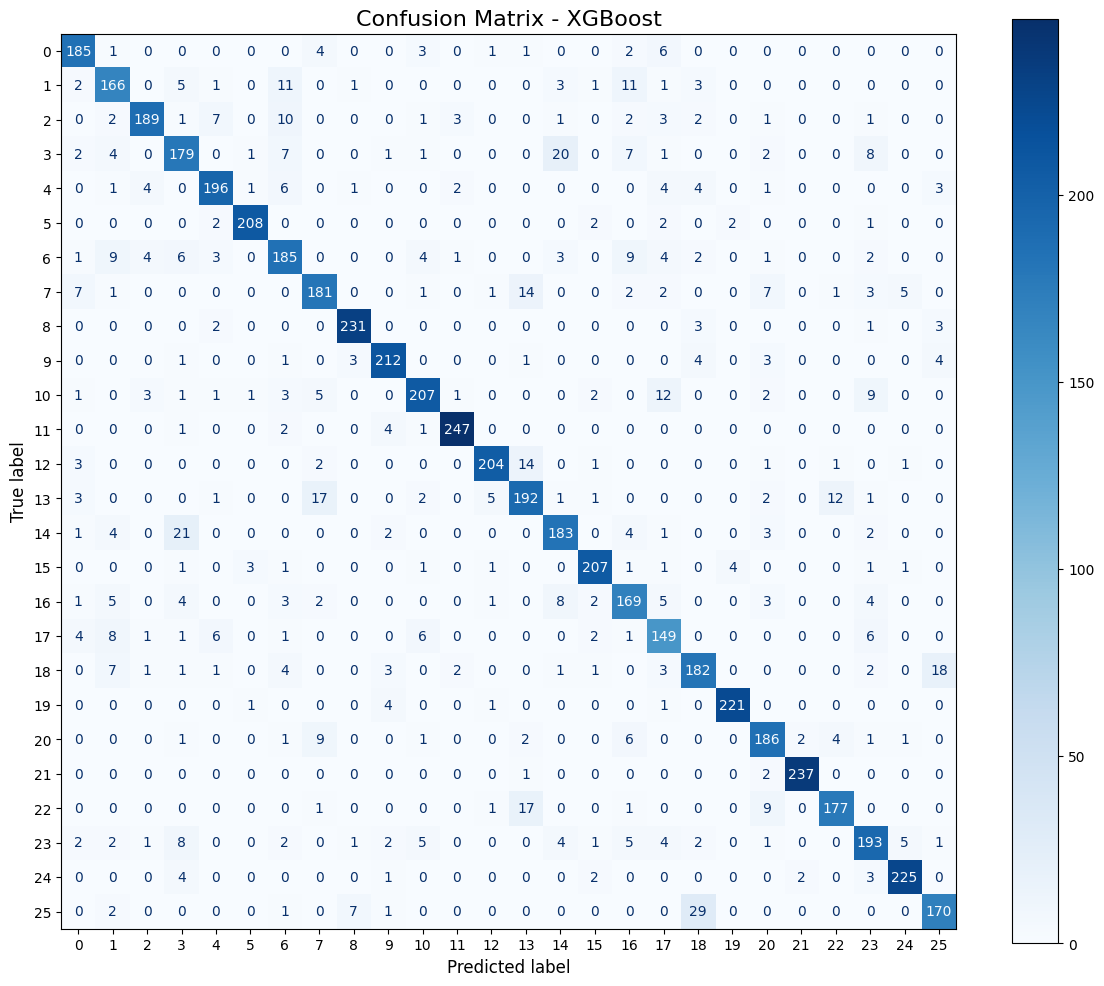

In [54]:
# Confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
cm = confusion_matrix(y_test, xgb_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap='Blues', colorbar=True)
ax.set_title("Confusion Matrix - XGBoost", fontsize=16)
ax.set_xlabel("Predicted label", fontsize=12)
ax.set_ylabel("True label", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


In [25]:
# XGB - K-Fold Cross Validation
xgb_kf = KFold(n_splits=3, shuffle=True, random_state=42)
results_xgb_kf = evaluate_cv_results(xgb_pipeline, X_train, y_train, xgb_kf, 'XGB - K-Fold')

# xgb - Stratified K-Fold Cross Validation
xgb_skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
results_xgb_skf = evaluate_cv_results(xgb_pipeline, X_train, y_train, xgb_skf, 'XGB - Stratified K-Fold')

# xgb - Stratified K-Fold dengan Best Estimator
results_xgb_best = evaluate_cv_results(xgb_model, X_train, y_train, xgb_skf, 'XGB - Stratified K-Fold + Best Estimator')


c:\Users\dazel\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:05:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\dazel\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:05:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\dazel\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:05:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGB - K-Fold ===
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       918
           1       0.74      0.76      0.75       917
           2       0.84      0.86      0.85       899
           3       0.71      0.71      0.71       889
           4       0.86      0.84      0.85       899
           5       0.98      0.97      0.98       905
           6       0.75      0.73      0.74       888
           7       0.77      0.79      0.78       897
           8       0.93      0.93      0.93       880
           9       0.90      0.90      0.90       893
          10       0.81      0.78      0.80       874
          11       0.95      0.97      0.96       867
          12       0.94      0.92      0.93       895
          13       0.75      0.75      0.75       885
          14       0.82      0.83      0.82       901
          15       0.91      0.91      0.91       900
          16       0.77      0.80      0.78       915
      

c:\Users\dazel\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:05:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\dazel\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:06:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\dazel\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:06:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGB - Stratified K-Fold ===
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       918
           1       0.73      0.76      0.74       917
           2       0.85      0.86      0.85       899
           3       0.70      0.69      0.69       889
           4       0.85      0.84      0.84       899
           5       0.98      0.97      0.97       905
           6       0.74      0.72      0.73       888
           7       0.76      0.80      0.78       897
           8       0.94      0.93      0.93       880
           9       0.91      0.89      0.90       893
          10       0.82      0.76      0.79       874
          11       0.95      0.96      0.96       867
          12       0.93      0.92      0.93       895
          13       0.76      0.74      0.75       885
          14       0.81      0.83      0.82       901
          15       0.91      0.91      0.91       900
          16       0.78      0.78      0.78      

c:\Users\dazel\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:06:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\dazel\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:06:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\dazel\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:06:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGB - Stratified K-Fold + Best Estimator ===
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       918
           1       0.75      0.77      0.76       917
           2       0.85      0.87      0.86       899
           3       0.71      0.71      0.71       889
           4       0.86      0.85      0.86       899
           5       0.98      0.97      0.98       905
           6       0.76      0.75      0.76       888
           7       0.77      0.80      0.78       897
           8       0.94      0.93      0.93       880
           9       0.93      0.89      0.91       893
          10       0.83      0.79      0.81       874
          11       0.95      0.97      0.96       867
          12       0.94      0.93      0.94       895
          13       0.79      0.78      0.79       885
          14       0.83      0.85      0.84       901
          15       0.92      0.91      0.92       900
          16       0.79      0.8

In [24]:
final_results_df = pd.DataFrame([
    {key: f"{value*100:.2f}%" if isinstance(value, float) else value for key, value in result.items()}
    for result in [results_xgb_kf, results_xgb_skf, results_xgb_best]
])
display(final_results_df)

CV Type Accuracy Precision  Recall  \
0                              XGB - K-Fold   84.53%    84.59%  84.53%   
1                   XGB - Stratified K-Fold   84.20%    84.26%  84.20%   
2  XGB - Stratified K-Fold + Best Estimator   85.40%    85.47%  85.40%   

  F1 Score  
0   84.54%  
1   84.21%  
2   85.42%

### Penjelasan Pengukuran Kinerja/Evaluasi Model (Akurasi, Presisi, Recall, F1-Score)

In [11]:
acc_knn = accuracy_score(y_test, knn_y_pred)
prec_knn = precision_score(y_test, knn_y_pred, average='weighted')
rec_knn = recall_score(y_test, knn_y_pred, average='weighted')
f1_knn = f1_score(y_test, knn_y_pred, average='weighted')

acc_rf = accuracy_score(y_test, rf_y_pred)
prec_rf = precision_score(y_test, rf_y_pred, average='weighted')
rec_rf = recall_score(y_test, rf_y_pred, average='weighted')
f1_rf = f1_score(y_test, rf_y_pred, average='weighted')

acc_xgb = accuracy_score(y_test, xgb_y_pred)
prec_xgb = precision_score(y_test, xgb_y_pred, average='weighted')
rec_xgb = recall_score(y_test, xgb_y_pred, average='weighted')
f1_xgb = f1_score(y_test, xgb_y_pred, average='weighted')

acc_mlp = accuracy_score(y_test, mlp_y_pred)
prec_mlp = precision_score(y_test, mlp_y_pred, average='weighted')
rec_mlp = recall_score(y_test, mlp_y_pred, average='weighted')
f1_mlp = f1_score(y_test, mlp_y_pred, average='weighted')

results_df = pd.DataFrame({
    'Model': ['KNN', 'Random Forest', 'MLP', 'XGBoost'],
    'Accuracy': [acc_knn, acc_rf, acc_mlp, acc_xgb],
    'Precision': [prec_knn, prec_rf, prec_mlp, prec_xgb],
    'Recall': [rec_knn, rec_rf, rec_mlp, rec_xgb],
    'F1 Score': [f1_knn, f1_rf, f1_mlp, f1_xgb]
})
display(results_df)


Model  Accuracy  Precision    Recall  F1 Score
0            KNN  0.823792   0.826344  0.823792  0.823152
1  Random Forest  0.841790   0.841764  0.841790  0.841092
2            MLP  0.900583   0.901638  0.900583  0.900664
3        XGBoost  0.870929   0.872246  0.870929  0.871288

## Penjelasan mengenai Uji Model menggunakan gambar kita sendiri

In [ ]:
def process_image_to_28x28_binary(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # Resize to 28x28 first to standardize input
    img_resized = cv2.resize(img, (28, 28), interpolation=cv2.INTER_AREA)

    # Invert colors: make it white-on-black
    # img_inverted = (img_resized / 255.0)
    img_inverted = 1.0 - (img_resized / 255.0)

    # Threshold to binary (optional, improve clarity)
    img_binary = (img_inverted > 0.1).astype(np.float32)

    # Crop to bounding box
    coords = np.column_stack(np.where(img_binary > 0))
    if coords.shape[0] == 0:
        return np.zeros((28, 28))

    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    cropped = img_binary[y_min:y_max+1, x_min:x_max+1]

    # Resize to 20x20 (preserve aspect ratio)
    h, w = cropped.shape
    scale = 20.0 / max(h, w)
    resized = cv2.resize(cropped, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_AREA)

    # Pad to 28x28 with centered image
    h_pad, w_pad = resized.shape
    pad_top = (28 - h_pad) // 2
    pad_bottom = 28 - h_pad - pad_top
    pad_left = (28 - w_pad) // 2
    pad_right = 28 - w_pad - pad_left

    final_img = np.pad(resized, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant')

    final_binary = (final_img > 0.1).astype(np.uint8)

    return final_binary

def extract_features(img):
    # img = (img > 0).astype(np.uint8)  # binary image

    # display(img)
    coords = np.column_stack(np.where(img > 0))
    if coords.shape[0] == 0:
        return [0] * 17

    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    width = x_max - x_min + 1
    height = y_max - y_min + 1
    onpix = np.count_nonzero(img)

    y_indices, x_indices = coords[:, 0], coords[:, 1]
    x_bar = np.mean(x_indices)
    y_bar = np.mean(y_indices)

    x2bar = np.var(x_indices)
    y2bar = np.var(y_indices)
    xybar = np.mean((x_indices - x_bar) * (y_indices - y_bar))
    x2ybr = np.mean((x_indices ** 2) * y_indices)
    xy2br = np.mean(x_indices * (y_indices ** 2))

    x_edge = np.mean(np.abs(np.diff(img, axis=1)).sum(axis=1))
    y_edge = np.mean(np.abs(np.diff(img, axis=0)).sum(axis=0))

    # display(np.abs(np.diff(img, axis=1)).sum(axis=1))
    # display(np.arange(28))
    xegvy = pearsonr(np.abs(np.diff(img, axis=1)).sum(axis=1), np.arange(28))[0]

    yegvx = pearsonr(np.abs(np.diff(img, axis=0)).sum(axis=0), np.arange(28))[0]

    res = np.array([
        x_min, y_min, width, height, onpix,
        x_bar, y_bar, x2bar, y2bar, xybar,
        x2ybr, xy2br, x_edge, xegvy, y_edge, yegvx
    ]).reshape(1, -1)

    columns = [
        "x_min", "y_min", "width", "height", "onpix",
        "x_bar", "y_bar", "x2bar", "y2bar", "xybar",
        "x2ybr", "xy2br", "x_edge", "xegvy", "y_edge", "yegvx"
    ]

    return pd.DataFrame(res, columns=columns)


with open('best_rf_model.pkl', 'rb') as file:
    rf_model = pickle.load(file)


for i in range(26):
    if i == 2:
        continue
    binary_img = process_image_to_28x28_binary(f'letter/{chr(65 + i)}.png')
    fitur = extract_features(binary_img)
    prediksi = rf_model.predict(fitur)[0]
    print(f"harusnya: {chr(65 + i)}, prediksi: {chr(prediksi + 65)}  |  {i == prediksi}")

harusnya: A, prediksi: A  |  True
harusnya: B, prediksi: X  |  False
harusnya: D, prediksi: X  |  False
harusnya: E, prediksi: E  |  True
harusnya: F, prediksi: F  |  True
harusnya: G, prediksi: G  |  True
harusnya: H, prediksi: H  |  True
harusnya: I, prediksi: Z  |  False
harusnya: J, prediksi: Y  |  False
harusnya: K, prediksi: X  |  False
harusnya: L, prediksi: L  |  True
harusnya: M, prediksi: H  |  False
harusnya: N, prediksi: H  |  False
harusnya: O, prediksi: X  |  False
harusnya: P, prediksi: P  |  True
harusnya: Q, prediksi: B  |  False
harusnya: R, prediksi: K  |  False
harusnya: S, prediksi: S  |  True
harusnya: T, prediksi: P  |  False
harusnya: U, prediksi: U  |  True
harusnya: V, prediksi: Y  |  False
harusnya: W, prediksi: Y  |  False
harusnya: X, prediksi: X  |  True
harusnya: Y, prediksi: Y  |  True
harusnya: Z, prediksi: Z  |  True


### Penjelasan mengenai 3 model yang akan digunakan untuk mengetahui klasifikasi dari data baru

In [15]:
for model, name in zip([knn_model, rf_model, mlp_model, xgb_model], ['KNN', 'Random Forest', 'Multilayer Perceptron', 'XGBoost']):
    print(name)
    for i in range(26):
        if i == 2:
            continue
        binary_img = process_image_to_28x28_binary(f'letter/{chr(65 + i)}.png')
        fitur = extract_features(binary_img)
        prediksi = model.predict(fitur)[0]
        print(f"harusnya: {chr(65 + i)}, prediksi: {chr(prediksi + 65)}  |  {i == prediksi}")
    print("---------------")

KNN
harusnya: A, prediksi: A  |  True
harusnya: B, prediksi: B  |  True
harusnya: D, prediksi: D  |  True
harusnya: E, prediksi: E  |  True
harusnya: F, prediksi: F  |  True
harusnya: G, prediksi: G  |  True
harusnya: H, prediksi: H  |  True
harusnya: I, prediksi: C  |  False
harusnya: J, prediksi: S  |  False
harusnya: K, prediksi: X  |  False
harusnya: L, prediksi: L  |  True
harusnya: M, prediksi: H  |  False
harusnya: N, prediksi: H  |  False
harusnya: O, prediksi: A  |  False
harusnya: P, prediksi: P  |  True
harusnya: Q, prediksi: B  |  False
harusnya: R, prediksi: R  |  True
harusnya: S, prediksi: S  |  True
harusnya: T, prediksi: T  |  True
harusnya: U, prediksi: U  |  True
harusnya: V, prediksi: Y  |  False
harusnya: W, prediksi: H  |  False
harusnya: X, prediksi: X  |  True
harusnya: Y, prediksi: Y  |  True
harusnya: Z, prediksi: Z  |  True
---------------
Random Forest
harusnya: A, prediksi: A  |  True
harusnya: B, prediksi: X  |  False
harusnya: D, prediksi: X  |  False
har

## KESIMPULAN/INTERPRETASI

Dari keempat model Machine Learning yang dilatih dan diuji menggunakan dataset, dihasilkan bahwa model Multilayer Perceptron memiliki akurasi yang tertinggi, yaitu mencapai 90.06% diikuti oleh Random Forest yang mencapai tingkat akurasi 84.18%, K-Nearest Neighbors Classifier yang mencapai tingkat akurasi 82.38%, dan XGBoost Classifier yang mencapai tingkat akurasi 87.09%. Ketiga model ini memiliki keunggulan dalam aspek akurasi dan performa dan dapat mengatasi serta menghindari overfitting. Akan tetapi, masing-masing model memiliki kekurangan. Random Forest Classification memerlukan komputasi yang tinggi dan potensi bias terhadap kelas mayoritas. K-Nearest Neighbors Classification membutuhkan komputasi yang tinggi pada data dengan skala besar dan memori yang besar. Apabila nilai k yang dipilih tidak optimal, maka akan terjadi overfitting dan underfitting. XGBoost Classification juga memiliki sejumlah parameter yang perlu ditetapkan untuk mencapai kinerja yang optimal. Dengan demikian, terdapat berbagai aspek dari segi waktu, komputasi, memori, dan lain-lain yang perlu dipertimbangkan dalam memilih model yang tepat untuk melakukan prediksi bagi data-data baru yang akan diujikan di masa depan. 
